In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# load data

In [2]:
root = Path('data/processed/')

In [3]:
orders_count = pd.read_csv(root / 'orders_count.csv')
orders_count.head(3)

,date,count,product_name,city_id
0,2017-01-01,1,fit,2
1,2017-01-03,144,fit,2
2,2017-01-04,0,fit,2


In [4]:
new_orders_count = pd.read_csv(root / 'new_orders_count.csv')
new_orders_count.head(3)

,date,count,product_name,city_id
0,2017-01-03,22,fit,2
1,2017-01-04,0,fit,2
2,2017-01-06,4,fit,2


In [6]:
fact_deliveries_count = pd.read_csv(root / 'fact_deliveries_count.csv')
fact_deliveries_count.head(3)

,count,planned_delivery_date,city_id,production_type_id,name
0,34,2022-10-27,2,185,elementaree_1
1,168,2022-10-26,1,19,balance_2_2
2,1,2022-10-26,1,20,detox_2_2


In [8]:
f = lambda s: s.split('_')[0]
fact_deliveries_count = fact_deliveries_count.assign(product_name=fact_deliveries_count.name.apply(f))
fact_deliveries_count.head(3)

,count,planned_delivery_date,city_id,production_type_id,name,product_name
0,34,2022-10-27,2,185,elementaree_1,elementaree
1,168,2022-10-26,1,19,balance_2_2,balance
2,1,2022-10-26,1,20,detox_2_2,detox


# make dataset

In [187]:
city_id = 1
product = 'balance'

df1 = orders_count[(orders_count.city_id == city_id) & (orders_count.product_name == product)]
df2 = new_orders_count[(new_orders_count.city_id == city_id) & (new_orders_count.product_name == product)]
df3 = fact_deliveries_count[(fact_deliveries_count.city_id == city_id) & 
                            (fact_deliveries_count.product_name == product)] \
            .rename({'planned_delivery_date': 'date'}, axis=1) #\
            # .drop_duplicates('date')
cols = ['date', 'count']

df = pd.merge(df1[cols], df2[cols], on='date')
df = df.rename(dict(count_x='orders_count',
                    count_y='new_orders_count'), axis=1)
df = pd.merge(df, df3[cols], on='date').rename(dict(count='deliveries_count'), axis=1)
df.sort_values('date', inplace=True)
df.head(3)

,date,orders_count,new_orders_count,deliveries_count
0,2017-08-13,20,2,290
1,2017-08-16,15,8,343
2,2017-08-18,45,21,130


In [188]:
q = df.date.value_counts()
df[df.date.isin(q[q > 1].index)].to_csv('./anomaly_deliveries_count', index=False)

In [59]:
def make_ticks(dates: pd.Series, ticks_n=10) -> pd.Series:
    if len(dates) < ticks_n:
        return dates

    q = len(dates) // ticks_n
    return dates[dates.index % q == 0]

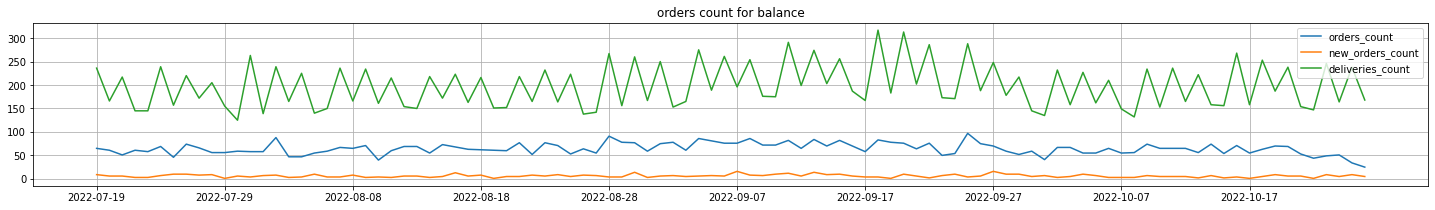

In [157]:
subdf = df.iloc[-100:]

plt.figure(figsize=(25, 3))
plt.title(f'orders count for {product}')
plt.grid(True)

cols = [
    'orders_count', 
    'new_orders_count', 
    'deliveries_count'
]
for col in cols:
    plt.plot(subdf.date, subdf[col])

plt.xticks(ticks=make_ticks(subdf.date, ticks_n=10))
plt.legend(cols)

plt.show()

# is the delivery decomposonal?

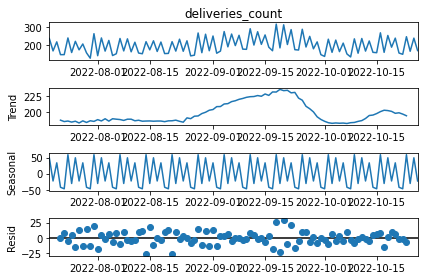

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose

d = pd.DataFrame(subdf)
d.index = pd.to_datetime(d.date)
d = d.drop('date', axis=1)

d = d.asfreq('1d')
d.fillna(method='ffill', inplace=True)

seasonal_decompose(d.deliveries_count, model='additive').plot()
plt.show()

[]

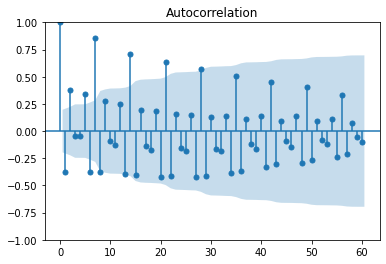

In [159]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(d.deliveries_count, lags=60)
plt.plot()

<AxesSubplot:xlabel='date'>

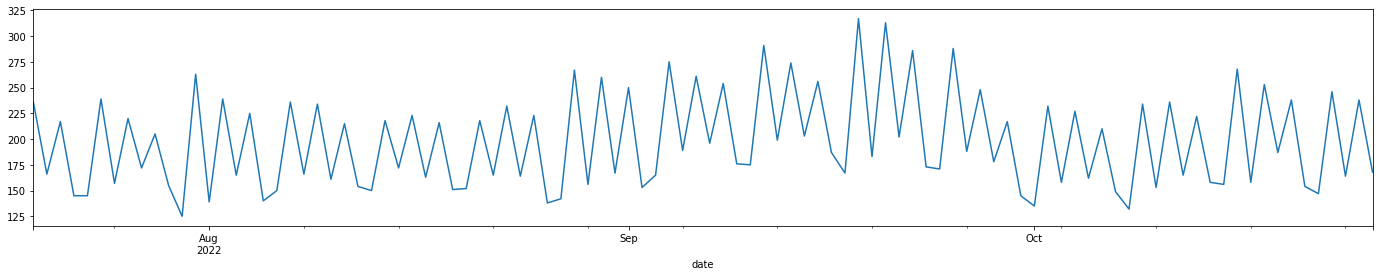

In [160]:
d.deliveries_count.plot(figsize=(24, 4))

# model with sarima

In [161]:
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
import itertools
from tqdm import tqdm_notebook

In [162]:
# setting initial values and some bounds for them
ps = range(2, 5)
dp=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  # 36


36

In [163]:
def optimizeSARIMA(x, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(x, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except Exception as e:
            print('err', e)
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [164]:
import warnings

warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(d.deliveries_count, parameters_list, dp, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

In [165]:
result_table.head(3)

,parameters,aic
0,"(3, 2, 1, 1)",731.558705
1,"(3, 2, 0, 1)",732.229797
2,"(3, 3, 1, 1)",734.777247


In [166]:
result_table.tail(3)

,parameters,aic
33,"(2, 4, 0, 0)",759.238663
34,"(4, 4, 0, 0)",759.364319
35,"(2, 2, 0, 0)",766.557399


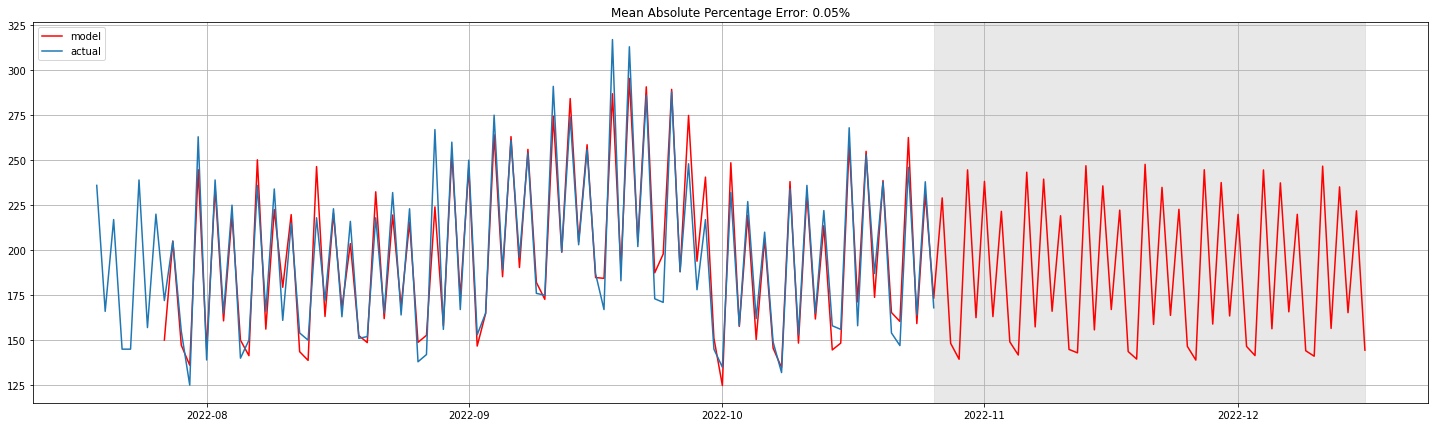

In [167]:
import numpy as np

def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = pd.DataFrame(series.copy())
    data.columns = ['actual']
    data = data.assign(sarima_model=model.fittedvalues)
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+dp] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+dp:], data['sarima_model'][s+dp:])

    plt.figure(figsize=(25, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

    
p, q, P, Q = result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(d.deliveries_count, order=(p, dp, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
plotSARIMA(d.deliveries_count, best_model, 50)